In [1]:
using LinearAlgebra
using SparseArrays
using Plots

In [2]:
using Revise
using LatticeQM

┌ Info: Precompiling LatticeQM [606d2a7e-9b17-11e9-1c5c-455b84f60309]
└ @ Base loading.jl:1278


In [3]:
using ProgressMeter; ProgressMeter.ijulia_behavior(:clear);

# Tutorial: Hubbard mean field

# Honeycomb lattice 1

In [4]:
lat = Geometries2D.honeycomb()
sx, sy, sz, sublA, sublB = getoperator(lat, ["SX", "SY", "SZ", "sublatticeAspin", "sublatticeBspin"])

hops = Operators.graphene(lat; mode=:spinhalf)
Operators.addzeeman!(hops, lat, r->sign(r[4]-0.5).*0.5.*[sin(0.0π),0,cos(0.0π)] )

ks = kpath(lat; num_points=200)

nothing

Computing bands... 100%|████████████████████████████████| Time: 0:00:03


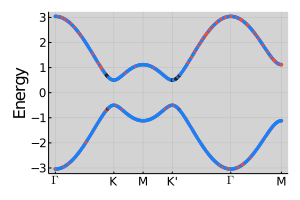

In [5]:
ks = kpath(lat; num_points=200)
bands = getbands(hops, ks, sz)
p1 = plot(bands; markersize=2, size=(300,200))

### Set up the interaction

In [6]:
v = gethubbard(lat; mode=:σx, a=0.5, U=5.0) # interaction potential
ρ_init = initialguess(v, :random; lat=lat) # initial guess
hf = hartreefock(hops, v)

nothing

In [8]:
Meanfield.getcappedyukawa(lat; format=:dense, mode=:nospin, k0=0.5, U=2.3)

Dict{Array{Int64,1},AbstractArray{T,2} where T} with 7 entries:
  [0, 1]  => Complex{Float64}[0.518442-0.0im 0.930014-0.0im; 0.263745-0.0im 0.5…
  [0, -1] => Complex{Float64}[0.518442+0.0im 0.263745+0.0im; 0.930014+0.0im 0.5…
  [-1, 0] => Complex{Float64}[0.518442+0.0im 0.263745+0.0im; 0.930014+0.0im 0.5…
  [0, 0]  => Complex{Float64}[2.3-0.0im 0.930014-0.0im; 0.930014-0.0im 2.3-0.0i…
  [-1, 1] => Complex{Float64}[0.518442-0.0im 0.423061-0.0im; 0.423061-0.0im 0.5…
  [1, 0]  => Complex{Float64}[0.518442-0.0im 0.930014-0.0im; 0.263745-0.0im 0.5…
  [1, -1] => Complex{Float64}[0.518442+0.0im 0.423061+0.0im; 0.423061+0.0im 0.5…

### Run mean field solver

In [14]:
ρ_sol, ϵ_GS, HMF, converged, error = Meanfield.solveselfconsistent( # run the calculation
    hf, ρ_init, 0.75; klin=30, iterations=800, tol=1e-7,# p_norm=Inf,
    T=0.01, β=0.25,  show_trace=true, clear_trace=true
)

nothing

FIXPOINT SEARCH  (thresh = 1e-07, value = 0.00252384)
4m  iter:  799

### Get magnetization

In [15]:
mA, mB = real.(Operators.magnetization(ρ_sol, [sublA,sublB], lat))
δM = mA - mB; M = mA+mB
Mabs = norm(M); δMabs = norm(δM)
dens = Operators.density(ρ_sol)
@info("Groundstate energy", ϵ_GS)
@info("Magnetization", Mabs, δMabs, M, δM)
@info("Density", dens)

┌ Info: Groundstate energy
│   ϵ_GS = 3.3215615278403092
└ @ Main In[15]:5
┌ Info: Magnetization
│   Mabs = 0.6135757249702254
│   δMabs = 0.39774436422062387
│   M = [0.15478524607646227, 0.44613558028547623, 0.39176490638280514]
│   δM = [0.0021600927207778564, 0.006226008252613213, 0.39768976613680207]
└ @ Main In[15]:6
┌ Info: Density
│   dens = 3.0000000000000506
└ @ Main In[15]:7


### Get bands

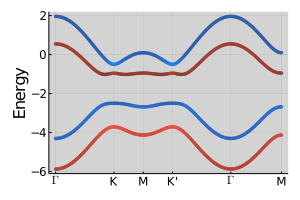

In [16]:
bands_mf = getbands(HMF.h, ks, sz)
bands_mf.bands .-= HMF.μ # shift chemical potential to zero
p2 = plot(bands_mf; markersize=2, size=(300,200))

### Comparison before and after

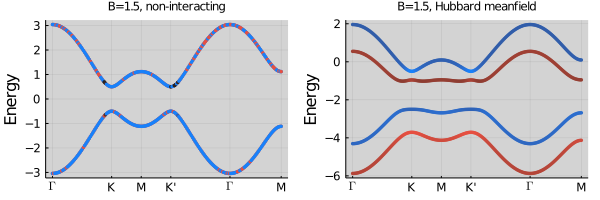

In [17]:
plot!(p1, title="B=1.5, non-interacting")
plot!(p2, title="B=1.5, Hubbard meanfield")
plot(p1,p2, titlefont=font(8), size=(600,200))

## Honeycomb lattice 2

In [18]:
using LatticeQM.Operators: graphene, addzeeman!, magnetization, density
using LatticeQM.Meanfield

roundreal(x; digits=7) = round.(real.(x); digits=digits)

function get_gap_at_U(U=4.0; filling=0.5, init=:antiferro, T=0.01, β=0.20, show_trace=true, show_bands=false, clear_trace=false, reportmagnetization=false)
    
    # Set up system
    lat = Geometries2D.honeycomb()
    sx, sy, sz, sublA, sublB = getoperator(lat, ["sx", "sy", "sz", "sublatticeAspin", "sublatticeBspin"])
    hops = graphene(lat; mode=:spinhalf)
#     addzeeman!(hops, lat, 0.0001)

    # Set up interaction and mean field hamiltonian
    v = gethubbard(lat; mode=:σx, a=0.5, U=U) # interaction potential
    ρ_init = initialguess(v, init; lat=lat) # initial guess

    hf = hartreefock(hops, v)

    # Solve mean field
    ρ_sol, ϵ_GS, HMF, converged, error = solveselfconsistent(
        hf, ρ_init, filling; klin=30, iterations=500, tol=1e-8,# p_norm=Inf,
        T=T, β=β,  show_trace=show_trace, clear_trace=clear_trace
    )

    # Calculate the gap size
    ks  = kpath(lat; num_points=200)
    gap = Spectrum.bandgap_filling(HMF.h, ks, filling)

    if show_bands
        bands = getbands(hops, ks, sz)
        p1 = plot(bands; size=(400,300))

        bandsMF = getbands(HMF.h, ks, sz)
        bandsMF.bands .-= HMF.μ

        p2 = plot(bandsMF; size=(400,300))
        p = plot(p1,p2, size=(800,300)) #gui(...)
        display(p)
    end

    if reportmagnetization
        mA, mB = roundreal.(magnetization(ρ_sol, [sublA,sublB], lat))
        δM = mA - mB
        M = mA+mB
        Mabs = norm(M)
        δMabs = norm(δM)
        dens = density(ρ_sol)
        @info("Groundstate energy", ϵ_GS)
        @info("Magnetization", Mabs, δMabs, mA, mB, M, δM)
        @info("Density", dens)
    end

    [gap ϵ_GS]
end

get_gap_at_U (generic function with 2 methods)

FIXPOINT SEARCH  Time: 0:00:15 (348 iterations)
  iter:  348


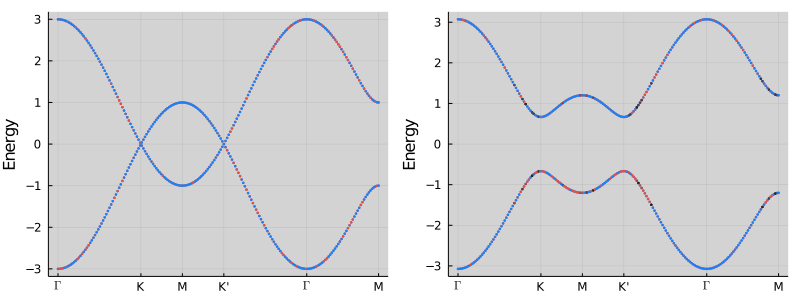

┌ Info: Groundstate energy
│   ϵ_GS = -1.681327105134354
└ @ Main In[18]:49
┌ Info: Magnetization
│   Mabs = 0.0
│   δMabs = 0.88821
│   mA = [-0.0, -0.0, 0.444105]
│   mB = [0.0, -0.0, -0.444105]
│   M = [0.0, -0.0, 0.0]
│   δM = [-0.0, 0.0, 0.88821]
└ @ Main In[18]:50
┌ Info: Density
│   dens = 2.000000000000001
└ @ Main In[18]:51


1×2 Array{Float64,2}:
 1.33234  -1.68133

In [19]:
get_gap_at_U(3.0; filling=0.5, init=:antiferro, T=0.01, β=0.15, show_bands=true, clear_trace=true, reportmagnetization=true)

### Sweep over interaction strengths and find interaction induced band gap 

In [20]:
using ProgressMeter

Us = range(0; stop=4.0, length=10)
data = progress_map(Us) do U
    get_gap_at_U(U; init=:antiferro, show_trace=false)
end

data = vcat(data...)
gap = data[:,1]
energies = data[:,2]

nothing

Progress: 100%|█████████████████████████████████████████| Time: 0:01:51


10-element Array{Float64,1}:
 -3.1489998533179957
 -2.9267776311081013
 -2.704555408907181
 -2.4823331867320535
 -2.260110964749294
 -2.0379905805757628
 -1.8237803586129515
 -1.6376644635975848
 -1.4805750866963314
 -1.347954014453142

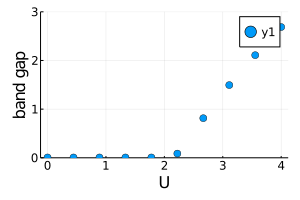

In [21]:
scatter(Us, gap; ylim=(0,3), size=(300,200), xlabel="U", ylabel="band gap")

# Triangular lattice

## Lattice

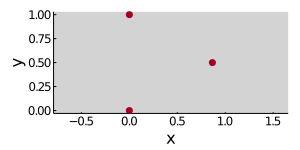

In [22]:
lat = Geometries2D.triangular_supercell()
sz = getoperator(lat, "sz")
sub1, sub2, sub3 = [getoperator(lat, "sublattice", i, 2) for i=1:3]

plot(lat, size=(300,150))

## Hamiltonian

In [23]:
hops = TightBinding.addspin(Operators.nearestneighbor!(Hops(), lat), :spinhalf)

nothing

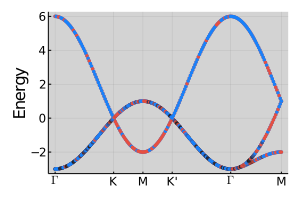

In [24]:
ks = kpath(lat; num_points=200)
bands = getbands(hops, ks, sz)
p1 = plot(bands; markersize=2, size=(300,200))

## Mean field

#### Setup

In [25]:
v = gethubbard(lat; mode=:σx, a=0.5, U=6.0) # interaction potential
ρ_init = initialguess(v, :random; lat=lat) # initial guess
hf = hartreefock(hops, v)

nothing

#### Solver

In [26]:
ρ_sol, ϵ_GS, HMF, converged, error = solveselfconsistent( # run the calculation
    hf, ρ_init, 0.5; klin=30, iterations=800, tol=1e-7,# p_norm=Inf,
    T=0.01, β=0.9,  show_trace=true, clear_trace=true
)

nothing

FIXPOINT SEARCH  Time: 0:00:05 (124 iterations)
  iter:  124


#### Result

In [27]:
m1,m2,m3 = real.(magnetization(ρ_sol, [sub1,sub2,sub3], lat))
m = m1+m2+m3
Mabs = norm(m)
dens = Operators.density(ρ_sol)
@info("Groundstate energy", ϵ_GS)
@info("Magnetizations", Mabs, norm(m1), norm(m2), norm(m3))
@info("Magnetization vectors", Mabs, m, m1, m2, m3)
@info("Density", dens)

┌ Info: Groundstate energy
│   ϵ_GS = -1.9374314751796828
└ @ Main In[27]:5
┌ Info: Magnetizations
│   Mabs = 1.3640257473603792e-6
│   norm(m1) = 0.8213600107831786
│   norm(m2) = 0.8213601968102726
│   norm(m3) = 0.8213601272920169
└ @ Main In[27]:6
┌ Info: Magnetization vectors
│   Mabs = 1.3640257473603792e-6
│   m = [7.441994006873731e-7, -5.083138339134763e-7, -1.023889905082953e-6]
│   m1 = [-0.2998137744035818, 0.07627238462818653, 0.7608721911955721]
│   m2 = [0.5470182341020374, -0.589008735025627, -0.1687374722093733]
│   m3 = [-0.24720371549905493, 0.5127358420836066, -0.5921357428761039]
└ @ Main In[27]:7
┌ Info: Density
│   dens = 2.9999999999999964
└ @ Main In[27]:8


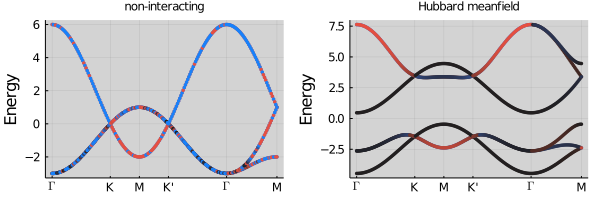

In [28]:
# Get the bands with mean-field terms
bands_mf = getbands(HMF.h, ks, sz)
bands_mf.bands .-= HMF.μ
p2 = plot(bands_mf; markersize=2, size=(600,200))

# Show the band structure side-by-side
plot!(p1, title="non-interacting")
plot!(p2, title="Hubbard meanfield")
plot(p1,p2, titlefont=font(8))

In [29]:
using DelimitedFiles
XYZ = transpose(Structure.positions(lat))
M = transpose(hcat([m1,m2,m3]...))
mkpath("output"); writedlm("output/positions.out", XYZ)
mkpath("output"); writedlm("output/magnetization.out", M)